# Table of Contents
 <p><div class="lev1 toc-item"><a href="#The-Push-relabel-Algorithm" data-toc-modified-id="The-Push-relabel-Algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Push-relabel Algorithm</a></div><div class="lev2 toc-item"><a href="#Initialization" data-toc-modified-id="Initialization-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialization</a></div><div class="lev2 toc-item"><a href="#Push" data-toc-modified-id="Push-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Push</a></div><div class="lev2 toc-item"><a href="#Main-Loop" data-toc-modified-id="Main-Loop-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Main Loop</a></div><div class="lev1 toc-item"><a href="#Summary" data-toc-modified-id="Summary-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Summary</a></div>

# The Push-relabel Algorithm

Push-relabel algorithmを実装してみる。

## Initialization

Initializeがきちんと動くか確認してみる。

In [17]:
def Initialize(G, s, t):
    '''
    Inputs:
        G: a graph
            V: verteces
                height
                excess
            E: edges
                flow(preflow)
                capacity
                    NB: flow <= capacity
        s: a start point
        t: an end point
    Output:
        None
    
    Initialize the height and excess of each vertex.
    '''
    for v in G.nodes():
        G.node[v]['excess'] = 0

    for v in G.nodes():
        # 始点以外の点について
        if v != s:
            G.node[v]['height'] = 0
            # G.node[v]['excess'] = 0
            for p in G.neighbors(v):
                G[v][p]['flow'] = 0
        # 始点について
        else:
            # 始点の高さをnに
            G.node[v]['height'] = G.number_of_nodes() # n
            # 始点から出る枝のpreflowをcapacityギリギリに
            # このとき、始点に隣接する点のexcessを更新
            for p in G.neighbors(v):
                G[v][p]['flow'] = G[v][p]['capacity']
                G.node[p]['excess'] = G[v][p]['flow']

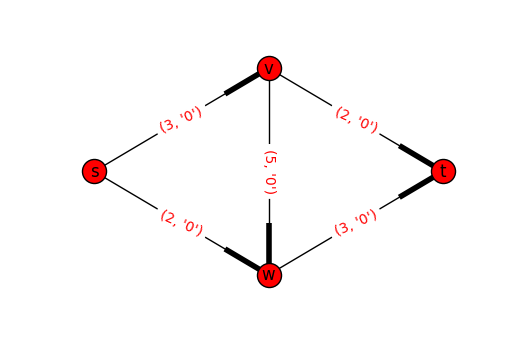

In [18]:
# もろもろをインポート
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# Lecture1の例のグラフGを生成
G = nx.DiGraph()
G.add_edges_from([('s','v',{'capacity': 3}),('s','w',{'capacity': 2}),('v','w',{'capacity': 5}),('v','t',{'capacity': 2}),('w','t',{'capacity': 3})])
for e in G.edges():
    G[e[0]][e[1]]['flow'] = 0

# 描画

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos)
plt.axis('off')
plt.show()

In [19]:
Initialize(G, 's', 't')

In [20]:
G.node['s']['height']

4

In [21]:
G.node['v']['height']

0

In [22]:
G.node['t']['height']

0

In [23]:
G.nodes()

['s', 't', 'w', 'v']

In [24]:
nodelist = G.nodes()
nodelist.remove('s')
for p in nodelist:
    print( 'the excess of the node ' + p +': ' + str(G.node[p]['excess']))

the excess of the node t: 0
the excess of the node w: 2
the excess of the node v: 3


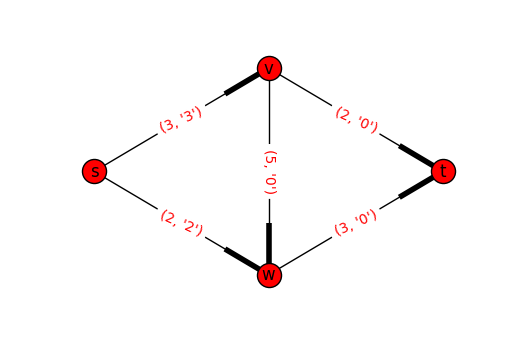

In [25]:
# 描画(flowがどう変わったか)
# heightも表示したいけどやり方がわからず

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos)
plt.axis('off')
plt.show()

上手く動いているみたいだ。

## Push

In [26]:
def makeResidualGraph(G):
    '''
    Input: a graph G
    Output: its residual graph Gf
    '''
    Gf = G.copy()
    edgeList = G.edges()
    
    # 逆向きのedgeがないものは追加
    for edge in edgeList:
        if not (edge[1], edge[0]) in edgeList:
            Gf.add_edge(edge[1],edge[0])
            Gf[edge[1]][edge[0]]['capacity'] = Gf[edge[0]][edge[1]]['flow']
            Gf[edge[1]][edge[0]]['flow'] = 0
    
    for edge in edgeList:
        Gf[edge[0]][edge[1]]['capacity'] = Gf[edge[0]][edge[1]]['capacity'] - Gf[edge[0]][edge[1]]['flow']
        Gf[edge[1]][edge[0]]['capacity'] = Gf[edge[0]][edge[1]]['flow']
        Gf[edge[0]][edge[1]]['flow'] = 0
        Gf[edge[1]][edge[0]]['flow'] = 0
    
    return Gf

In [27]:
import numpy as np
def Push(G, v, w, forwardEdges):
    '''
    G: a graph(a residual graph)
    v, w: vertices of G such that h(v) = h(w) + 1
    forwardEdges: a list of the edges of the original graph
    '''

    # 更新量diffを計算
    residualCapacity = G[v][w]['capacity'] - G[v][w]['flow']
    diff = np.min([G.node[v]['excess'], residualCapacity])

    # (v,w), (w,v)を更新, p.3を参考に
    if (v,w) in forwardEdges:
        G[v][w]['flow'] += diff
        G[w][v]['capacity'] += diff
        G.node[v]['excess'] -= diff
        G.node[w]['excess'] += diff
    else:
        G[v][w]['flow'] -= diff
        G[w][v]['capacity'] -= diff
        G.node[v]['excess'] += diff
        G.node[w]['excess'] -= diff

## Main Loop

In [28]:
def loopCondition(G, s, t):
    nodelist = G.nodes()
    nodelist.remove(s)
    nodelist.remove(t)

    for v in nodelist:
        if(G.node[v]['excess'] > 0):
            return True
    return False

def PushRelabel(G, s, t):
    '''
    Inputs:
        G: a graph
        s: a starting point
        t: an end point
    Output:
        the graph G with its maximum flow
    '''

    # Forward Edges を記録
    forwardEdges = G.edges()

    # s,tを除いたnodeのlistを作る
    nodeList = G.nodes()
    nodeList.remove(s)
    nodeList.remove(t)

    # residual graph の作成
    Gf = makeResidualGraph(G)

    # Initialization
    Initialize(Gf, s, t)

    # Main Loop
    while(loopCondition(Gf, s, t)):
        # 高さが最も高く、かつexcess > 0の点を探す
        height = -100 # 適当に負の値を設定
        for p in nodeList:
            if(Gf.node[p]['excess'] > 0 and Gf.node[p]['height'] > height):
                v = p
                height = Gf.node[p]['height']

        # h(v) = h(w) + 1 を満たす点wを探す
        w = None
        for p in Gf.nodes():
            if(Gf.node[v]['height'] == Gf.node[p]['height'] + 1 and (Gf[v][p]['capacity'] - Gf[v][p]['flow']) > 0):
                w = p
                break

        # そのような点wがない場合、increment h(v)
        if w == None:
            Gf.node[v]['height'] += 1

        # ある場合
        else:
            Push(Gf, v, w, forwardEdges)

    # もともと無かったedgeを消去
    for edge in Gf.edges():
        if not edge in forwardEdges:
            Gf.remove_edge(edge[0],edge[1])
    
    return Gf

*PushRelabel* が動くかどうか試してみる

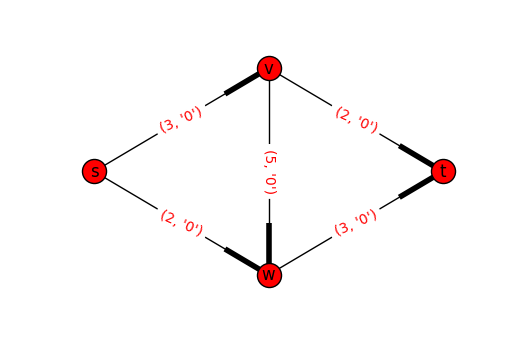

In [29]:
# もろもろをインポート
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# Lecture1の例のグラフGを生成
G = nx.DiGraph()
G.add_edges_from([('s','v',{'capacity': 3}),('s','w',{'capacity': 2}),('v','w',{'capacity': 5}),('v','t',{'capacity': 2}),('w','t',{'capacity': 3})])
for e in G.edges():
    G[e[0]][e[1]]['flow'] = 0

# 描画

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos)
plt.axis('off')
plt.show()

In [30]:
G = PushRelabel(G, 's', 't')

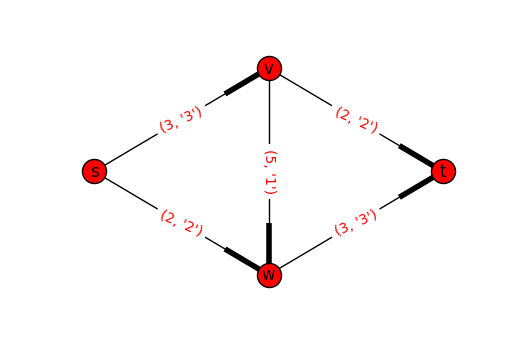

In [31]:
# 描画(flowがどう変わったか)
# heightも表示したいけどやり方がわからず

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos)
plt.axis('off')
plt.show()

上手く動いていそう

# Summary

最後に、今回作った関数をまとめておく。

*ch03_pushrelabel.py*というファイルで保存してある。

In [32]:
def Initialize(G, s, t):
    '''
    Inputs:
        G: a graph
            V: verteces
                height
                excess
            E: edges
                flow(preflow)
                capacity
                    NB: flow <= capacity
        s: a start point
        t: an end point
    Output:
        None
    
    Initialize the height and excess of each vertex.
    '''
    for v in G.nodes():
        G.node[v]['excess'] = 0

    for v in G.nodes():
        # 始点以外の点について
        if v != s:
            G.node[v]['height'] = 0
            # G.node[v]['excess'] = 0
            for p in G.neighbors(v):
                G[v][p]['flow'] = 0
        # 始点について
        else:
            # 始点の高さをnに
            G.node[v]['height'] = G.number_of_nodes() # n
            # 始点から出る枝のpreflowをcapacityギリギリに
            # このとき、始点に隣接する点のexcessを更新
            for p in G.neighbors(v):
                G[v][p]['flow'] = G[v][p]['capacity']
                G.node[p]['excess'] = G[v][p]['flow']

def Push(G, v, w, forwardEdges):
    '''
    G: a graph(a residual graph)
    v, w: vertices of G such that h(v) = h(w) + 1
    forwardEdges: a list of the edges of the original graph
    '''

    # 更新量diffを計算
    residualCapacity = G[v][w]['capacity'] - G[v][w]['flow']
    diff = np.min([G.node[v]['excess'], residualCapacity])

    # (v,w), (w,v)を更新, p.3を参考に
    if (v,w) in forwardEdges:
        G[v][w]['flow'] += diff
        G[w][v]['capacity'] += diff
        G.node[v]['excess'] -= diff
        G.node[w]['excess'] += diff
    else:
        G[v][w]['flow'] -= diff
        G[w][v]['capacity'] -= diff
        G.node[v]['excess'] += diff
        G.node[w]['excess'] -= diff

def loopCondition(G, s, t):
    nodelist = G.nodes()
    nodelist.remove(s)
    nodelist.remove(t)

    for v in nodelist:
        if(G.node[v]['excess'] > 0):
            return True
    return False

def PushRelabel(G, s, t):
    '''
    Inputs:
        G: a graph
        s: a starting point
        t: an end point
    Output:
        the graph G with its maximum flow
    '''

    # Forward Edges を記録
    forwardEdges = G.edges()

    # s,tを除いたnodeのlistを作る
    nodeList = G.nodes()
    nodeList.remove(s)
    nodeList.remove(t)

    # residual graph の作成
    Gf = makeResidualGraph(G)

    # Initialization
    Initialize(Gf, s, t)

    # Main Loop
    while(loopCondition(Gf, s, t)):
        # 高さが最も高く、かつexcess > 0の点を探す
        height = -100 # 適当に負の値を設定
        for p in nodeList:
            if(Gf.node[p]['excess'] > 0 and Gf.node[p]['height'] > height):
                v = p
                height = Gf.node[p]['height']

        # h(v) = h(w) + 1 を満たす点wを探す
        w = None
        for p in Gf.nodes():
            if(Gf.node[v]['height'] == Gf.node[p]['height'] + 1 and (Gf[v][p]['capacity'] - Gf[v][p]['flow']) > 0):
                w = p
                break

        # そのような点wがない場合、increment h(v)
        if w == None:
            Gf.node[v]['height'] += 1

        # ある場合
        else:
            Push(Gf, v, w, forwardEdges)

    # もともと無かったedgeを消去
    for edge in Gf.edges():
        if not edge in forwardEdges:
            Gf.remove_edge(edge[0],edge[1])
    
    return Gf

例のグラフを作るのと、描画するのも便利なので、再掲しておく。

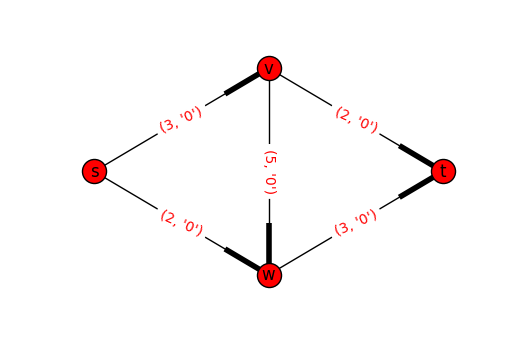

In [33]:
# 例のグラフを作成

# もろもろをインポート
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# Lecture1の例のグラフGを生成
G = nx.DiGraph()
G.add_edges_from([('s','v',{'capacity': 3}),('s','w',{'capacity': 2}),('v','w',{'capacity': 5}),('v','t',{'capacity': 2}),('w','t',{'capacity': 3})])
for e in G.edges():
    G[e[0]][e[1]]['flow'] = 0

# 描画

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos)
plt.axis('off')
plt.show()

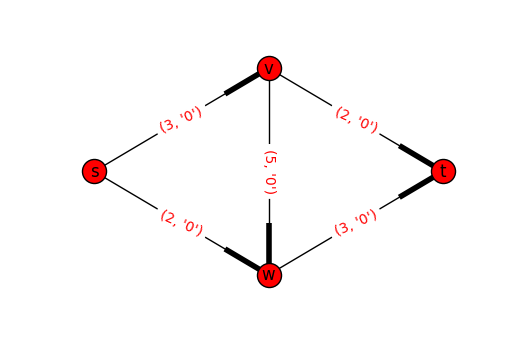

In [34]:
# 描画(flowがどう変わったか)
# heightも表示したいけどやり方がわからず

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos)
plt.axis('off')
plt.show()